# properties of each water mass and how they vary

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

# for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
def organize(s_t, do_no3, ta_dic, region, final=True):
    # make dictionary of transport and tracer concentrations of each water parcel within a specified region
    
    # the region is based on the boolean input into the function defined here
    # region options are salish, cuc, offshore deep, offshore surface, north, south, fresh, loop
    mydata= s_t
    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4
    saltdiv = 32
    sdiv = 33.5
    if region == 'salish':
        boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section))
    elif region == 'cuc':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    elif region == 'offshore deep':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    elif region == 'offshore surface':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    elif region == 'north':
        boolean = (mydata.final_section==bdy_nor)
    elif region == 'south':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    elif region == 'fresh':
        boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    elif region == 'loop':
        boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    else:
        print('not in the list of regions, options are: salish, cuc, offshore deep, offshore surface, north, south, fresh, loop')
    


    if final==True: # ie. looking at the water parcels at the outer boundaries
        # get data
        transport = mydata.init_transp[boolean].values
        salt = mydata.init_salt[boolean].values
        temp = mydata.init_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.init_salt[boolean].values
        DO = mydata.init_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.init_salt[boolean].values
        TA = mydata.init_temp[boolean].values
    else: # ie. looking at the water parcels at the JdF boundary
        # get data
        transport = mydata.final_transp[boolean].values
        salt = mydata.final_salt[boolean].values
        temp = mydata.final_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.final_salt[boolean].values
        DO = mydata.final_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.final_salt[boolean].values
        TA = mydata.final_temp[boolean].values

    # set up dictionary
    d = {'transport':transport,'salt':salt,'temp':temp,'DO':DO,'NO3':NO3,'TA':TA,'DIC':DIC}
    df = pd.DataFrame(d)

    return df

## Properties into JdF

In [3]:
region = 'salish'
final = False

up13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20131024/ariane_positions_quantitative.nc'),
             region, final)

up14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'),
             region, final)

up15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20150905/ariane_positions_quantitative.nc'),
             region, final)

up16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'),
             region, final)

up17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20171012/ariane_positions_quantitative.nc'),
             region, final)

up18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20180906/ariane_positions_quantitative.nc'),
             region, final)

up19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20191105/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20191105/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20191105/ariane_positions_quantitative.nc'),
             region, final)

up20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20201017/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20201017/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20201017/ariane_positions_quantitative.nc'),
             region, final)

up21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'),
             region, final)

up22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'),
             region, final)

up23 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20230922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20230922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20230922/ariane_positions_quantitative.nc'),
             region, final)

In [4]:
dw13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'),
             region, final)

dw14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20150212/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20150212/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20150212/ariane_positions_quantitative.nc'),
             region, final)

dw15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'),
             region, final)

dw16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20170419/ariane_positions_quantitative.nc'),
             region, final)

dw17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20180201/ariane_positions_quantitative.nc'),
             region, final)

dw18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20190406/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20190406/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20190406/ariane_positions_quantitative.nc'),
             region, final)

dw19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20200127/ariane_positions_quantitative.nc'),
             region, final)

dw20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'),
             region, final)

dw21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'),
             region, final)

dw22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20230419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20230419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20230419/ariane_positions_quantitative.nc'),
             region, final)

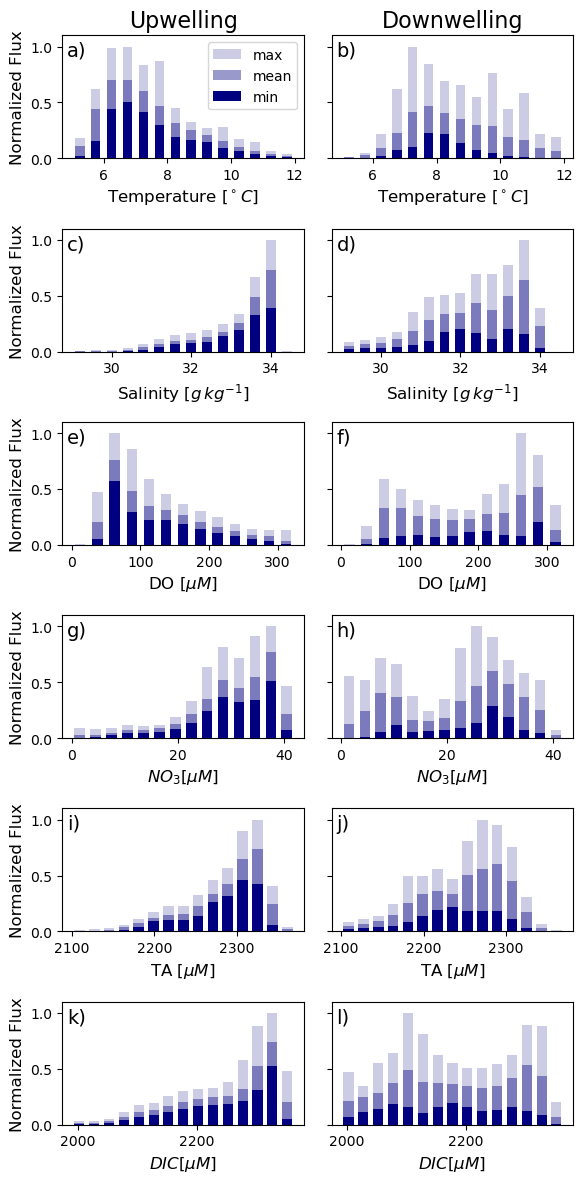

In [5]:
fig, ax = plt.subplots(6, 2, figsize = (6, 12))
plt.rcParams['font.size'] = 12

#TEMPERATURE
bins = np.arange(5,12.5,0.5)
#plt upwelling
h,x,_ = ax[0,0].hist([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up19.temp,up20.temp,up21.temp,up22.temp,up23.temp], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Upwelling', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[0,1].hist([dw13.temp,dw14.temp,dw15.temp,dw16.temp,dw17.temp,dw18.temp,dw19.temp,dw20.temp,dw21.temp,dw22.temp], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Downwelling', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#SALINITY
bins = np.arange(29,34.8,0.4)
#plt upwelling
h,x,_ = ax[1,0].hist([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up19.salt,up20.salt,up21.salt,up22.salt,up23.salt], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[1,1].hist([dw13.salt,dw14.salt,dw15.salt,dw16.salt,dw17.salt,dw18.salt,dw19.salt,dw20.salt,dw21.salt,dw22.salt], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,1.1])

#DO
bins = np.arange(0,350,25)
#plt upwelling
h,x,_ = ax[2,0].hist([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up19.DO,up20.DO,up21.DO,up22.DO,up23.DO], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,0].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,0].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,0].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[2,0].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[2,1].hist([dw13.DO,dw14.DO,dw15.DO,dw16.DO,dw17.DO,dw18.DO,dw19.DO,dw20.DO,dw21.DO,dw22.DO], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,1].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,1].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,1].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,1].set_yticklabels([])
ax[2,1].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#NO3
bins = np.arange(0,45,3)
#plt upwelling
h,x,_ = ax[3,0].hist([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up19.NO3,up20.NO3,up21.NO3,up22.NO3,up23.NO3], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,0].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,0].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean'),up23.transport
ax[3,0].bar(bin_centers, mini,width = 2, color='navy',label='min')

# ax[0].set_title('Winter')
ax[3,0].set_ylabel('Normalized Flux', fontsize=12)
ax[3,0].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[3,1].hist([dw13.NO3,dw14.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw18.NO3,dw19.NO3,dw20.NO3,dw21.NO3,dw22.NO3], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,1].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,1].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,1].bar(bin_centers, mini,width = 2, color='navy',label='min')


ax[3,1].set_yticklabels([])#,fontsize=14)
ax[3,1].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,1].set_ylim([0,1.1])

#TA
bins = np.arange(2100,2380,18)
#plt upwelling
h,x,_ = ax[4,0].hist([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up19.TA,up20.TA,up21.TA,up22.TA,up23.TA], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,0].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,0].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,0].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[4,0].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[4,1].hist([dw13.TA,dw14.TA,dw15.TA,dw16.TA,dw17.TA,dw18.TA,dw19.TA,dw20.TA,dw21.TA,dw22.TA], bins=bins,
                             weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,1].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,1].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,1].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,1].set_yticklabels([])
ax[4,1].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#DIC
bins = np.arange(1990,2380,25)
#plt upwelling
h,x,_ = ax[5,0].hist([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up19.DIC,up20.DIC,up21.DIC,up22.DIC,up23.DIC], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up19.transport,up20.transport,up21.transport,up22.transport,up23.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,0].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,0].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,0].bar(bin_centers, mini,width = 17, color='navy',label='min')

ax[5,0].set_ylabel('Normalized Flux', fontsize=12)
ax[5,0].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[5,1].hist([dw13.DIC,dw14.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw18.DIC,dw19.DIC,dw20.DIC,dw21.DIC,dw22.DIC], bins=bins, 
                           weights= [dw13.transport,dw14.transport,dw15.transport,dw16.transport,dw17.transport,dw18.transport,dw19.transport,dw20.transport,dw21.transport,dw22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,1].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,1].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,1].bar(bin_centers, mini,width = 17, color='navy',label='min')


ax[5,1].set_yticklabels([])#,fontsize=14)
ax[5,1].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,1].set_ylim([0,1.1])

#labels#labels#labels
ax[0,0].text(.02, .8, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .8, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)
ax[1,0].text(.02, .8, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .8, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)
ax[2,0].text(.02, .8, 'e)', ha='left', va='bottom', transform=ax[2,0].transAxes, fontsize=14)
ax[2,1].text(.02, .8, 'f)', ha='left', va='bottom', transform=ax[2,1].transAxes, fontsize=14)
ax[3,0].text(.02, .8, 'g)', ha='left', va='bottom', transform=ax[3,0].transAxes, fontsize=14)
ax[3,1].text(.02, .8, 'h)', ha='left', va='bottom', transform=ax[3,1].transAxes, fontsize=14)
ax[4,0].text(.02, .8, 'i)', ha='left', va='bottom', transform=ax[4,0].transAxes, fontsize=14)
ax[4,1].text(.02, .8, 'j)', ha='left', va='bottom', transform=ax[4,1].transAxes, fontsize=14)
ax[5,0].text(.02, .8, 'k)', ha='left', va='bottom', transform=ax[5,0].transAxes, fontsize=14)
ax[5,1].text(.02, .8, 'l)', ha='left', va='bottom', transform=ax[5,1].transAxes, fontsize=14)

plt.tight_layout()

## interannual variability

In [6]:
up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2023.csv')

dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2023.csv')

In [7]:
def interannual(region, property, updown):
    if updown == 'up':
        files = [up13, up14, up15, up16, up17, up18, up19, up20, up21, up22, up23]
    elif updown == 'down':
        files = [dw13, dw14, dw15, dw16, dw17, dw18, dw19, dw20, dw21, dw22]
    elif updown == 'both':
        files = [up13, dw13, up14, dw14, up15, dw15, up16, dw16, up17, dw17, up18, dw18, up19, dw19, up20, dw20, up21, dw21, up22, dw22, up23]

    data = np.zeros(len(files))
    i = 0
    for file in files:
        data[i] = file[property][file.regions == region]
        i+=1
    return data

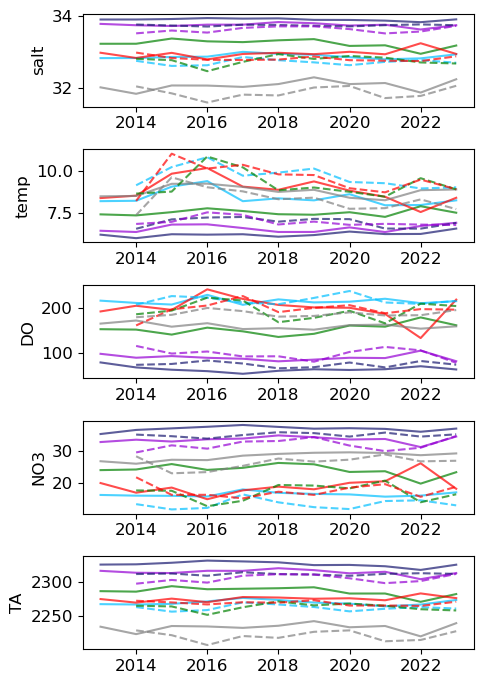

In [8]:
upyears = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
downyears = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].plot(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7)
    ax[i].plot(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7)
    ax[i].plot(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7)
    # ax[i].plot(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7)
    ax[i].plot(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7)
    ax[i].plot(downyears, interannual('cuc', properties[i], 'down'),ls='dashed',c='midnightblue',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore deep', properties[i], 'down'),ls='dashed',c='darkviolet',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore surface', properties[i], 'down'),ls='dashed',c='deepskyblue',alpha=0.7)
    ax[i].plot(downyears, interannual('north', properties[i], 'down'),ls='dashed',c='green',alpha=0.7)
    ax[i].plot(downyears, interannual('south', properties[i], 'down'),ls='dashed',c='red',alpha=0.7)
    # ax[i].plot(downyears, interannual('fresh', properties[i], 'down'),ls='dashed',c='magenta',alpha=0.7)
    ax[i].plot(downyears, interannual('loop', properties[i], 'down'),ls='dashed',c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

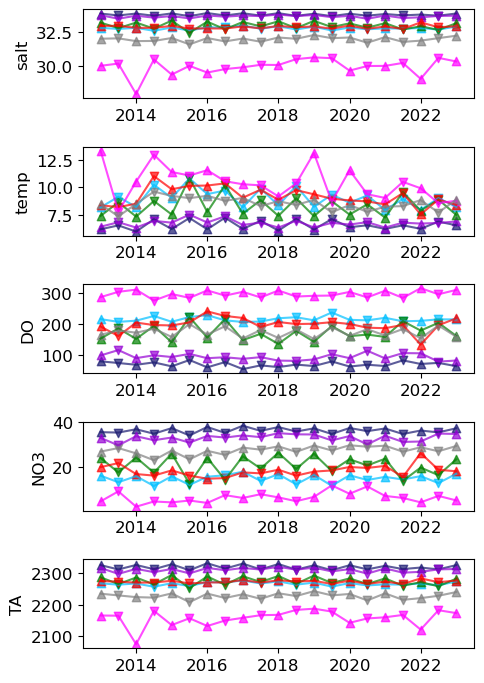

In [9]:
updownyears = np.sort(np.append(np.array(upyears),(np.array(downyears) - 0.5)))
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].scatter(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears) - 0.5, interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('fresh', properties[i], 'down'),c='magenta',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.7)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.7)
    ax[i].plot(updownyears, interannual('fresh', properties[i], 'both'),c='magenta',alpha=0.7)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

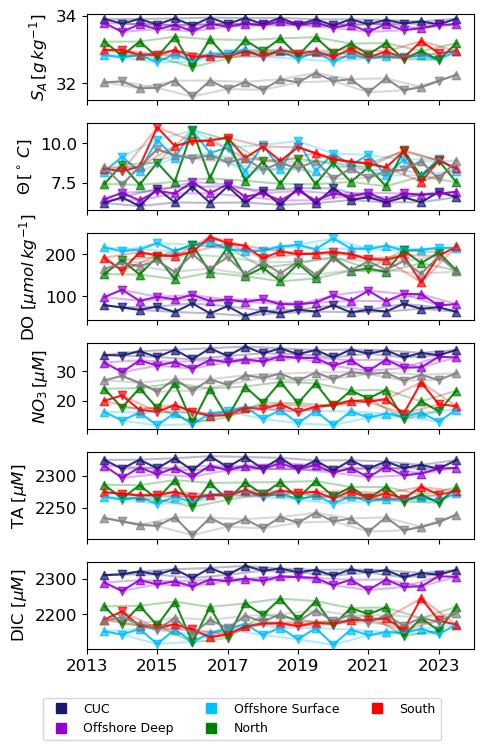

In [10]:
# don't actually keep fresh for final publication... too different from other water masses it makes the y-axis range bad
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','TA','DIC']
prop_names = ['$S_A \,[g\, kg^{-1}]$','$\Theta \,[^\circ \, C]$','DO $[\mu mol \, kg^{-1}]$','$NO_3 \, [\mu M]$','TA $[\mu M]$','DIC $[\mu M]$']

fig, ax = plt.subplots(6,1,figsize=(5,7))

for i in range(len(ax)):

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.9)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax[i].scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax[i].plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax[i].plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='green',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax[i].set_xticks(upyears[::2])
    ax[i].set_xticklabels([])
    ax[i].set_ylabel(prop_names[i])

ax[5].set_xticklabels(upyears[::2])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['midnightblue','darkviolet','deepskyblue','green','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.tight_layout()
# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

In [11]:
######################
# BOX PLOT FUNCTIONS #
######################
def box(regions,property,updown,ax,**kwargs):
    tracer = [interannual(region, property, updown) for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ax.set_xticks([])

    return bplot

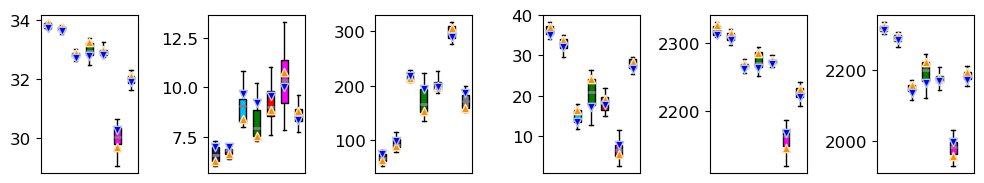

In [12]:
# box plots of the same data
# first using all the already averaged information
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red','magenta','grey']
fig,ax = plt.subplots(1,6,figsize=(10,2))

regions = up13.regions[1:]
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4)


    # add upwelling and downwelling means

plt.tight_layout()

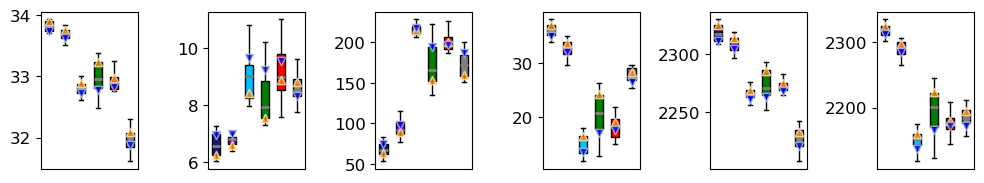

In [13]:
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
fig,ax = plt.subplots(1,6,figsize=(10,2))
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4,alpha=0.8)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4,alpha=0.8)


    # add upwelling and downwelling means

plt.tight_layout()

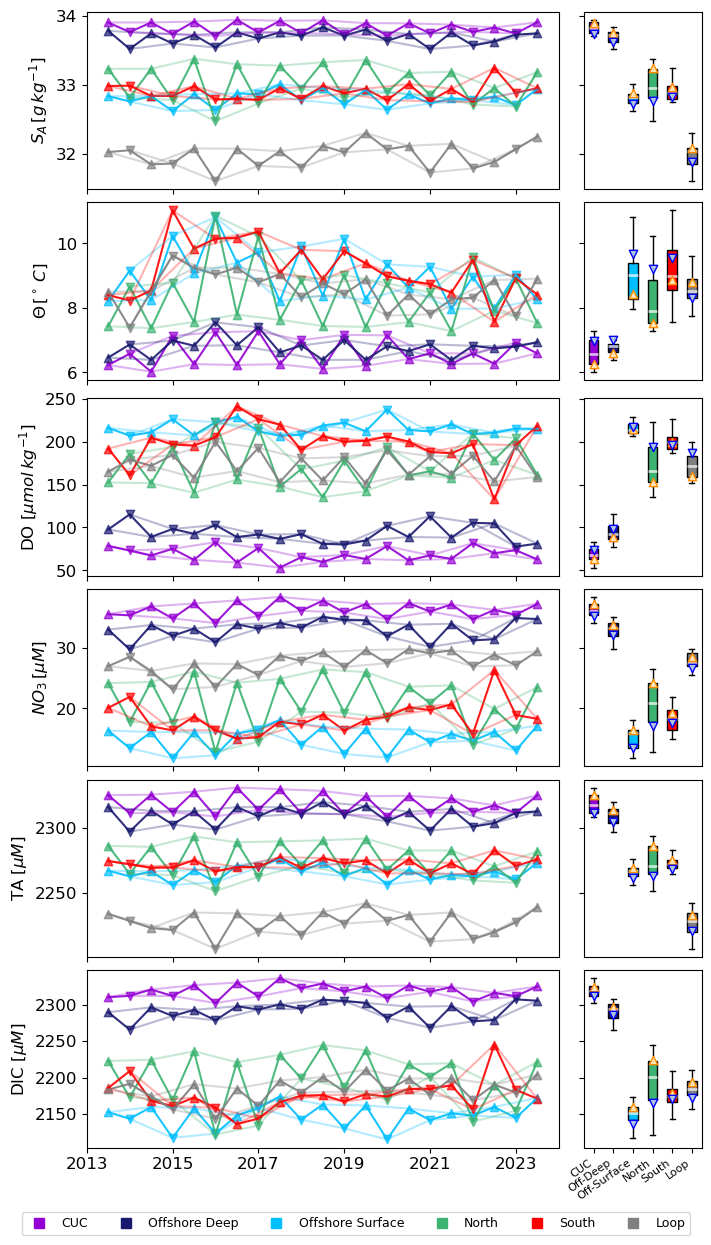

In [14]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','TA','DIC']
prop_names = ['$S_A \,[g\, kg^{-1}]$','$\Theta \,[^\circ \, C]$','DO $[\mu mol \, kg^{-1}]$','$NO_3 \, [\mu M]$','TA $[\mu M]$','DIC $[\mu M]$']

fig = plt.figure(constrained_layout=True, figsize=[7,2*6])
gs = GridSpec(6, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9,ax11]:

    ax.plot(updownyears, interannual('cuc', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax.plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax.plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax.plot(updownyears, interannual('north', properties[i], 'both'),c='mediumseagreen',alpha=0.9)
    ax.plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax.plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax.scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax.scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax.plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax.plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax11.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'mediumseagreen', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10,ax12]:
    bplot = box(regions,properties[i],'both',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.set_yticks([])
    i+=1
ax12.set_xticks(np.arange(1,len(regions)+1))
ax12.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South','Loop'],rotation=35,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)
ax12.sharey(ax11)
ax12.tick_params(axis='y', which='both', labelleft=False)

# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

In [15]:
prop='salt'
d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface':interannual('offshore surface', prop, 'both'),
         'north':interannual('north', prop, 'both'),
         'south':interannual('south', prop, 'both'),
         'loop':interannual('loop', prop, 'both'),
         'fresh':interannual('fresh', prop, 'both'),}
mydata = pd.DataFrame(d)

np.mean(mydata['cuc']) - np.mean(mydata['north'])

0.8103905383826486

In [16]:
# statistics of combined periods
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface': interannual('offshore surface', prop, 'both'),
         'north': interannual('north', prop, 'both'),
         'south': interannual('south', prop, 'both'),
         'loop': interannual('loop', prop, 'both'),
         'fresh': interannual('fresh', prop, 'both')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.8827    True   8.662797
1                cuc              loop   -1.8378    True  13.245105
2                cuc             north   -0.8104    True   4.078014
3                cuc     offshore deep   -0.1360   False   1.510869
4                cuc  offshore surface   -1.0167    True  10.470453
5                cuc             south   -0.9259    True   8.975799
6              fresh              loop    2.0449    True  -4.433003
7              fresh             north    3.0723    True  -6.364510
8              fresh     offshore deep    3.7467    True  -8.343754
9              fresh  offshore surface    2.8660    True  -6.361683
10             fresh             south    2.9568    True  -6.543614
11              loop             north    1.0274    True  -4.53

In [17]:
# statistics of upwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'up'),
         'offshore deep': interannual('offshore deep', prop, 'up'),
         'offshore surface': interannual('offshore surface', prop, 'up'),
         'north': interannual('north', prop, 'up'),
         'south': interannual('south', prop, 'up'),
         'loop': interannual('loop', prop, 'up'),
         'fresh': interannual('fresh', prop, 'up')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -4.2289    True   8.089554
1                cuc              loop   -1.8196    True  18.505527
2                cuc             north   -0.6643    True   7.741337
3                cuc     offshore deep   -0.1499   False   3.501896
4                cuc  offshore surface   -1.0158    True  20.223509
5                cuc             south   -0.9350    True  11.305497
6              fresh              loop    2.4093    True  -4.537321
7              fresh             north    3.5647    True  -6.740829
8              fresh     offshore deep    4.0790    True  -7.790907
9              fresh  offshore surface    3.2131    True  -6.129350
10             fresh             south    3.2939    True  -6.234714
11              loop             north    1.1554    True  -9.12

In [18]:
# statistics of downwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'down'),
         'offshore deep': interannual('offshore deep', prop, 'down'),
         'offshore surface': interannual('offshore surface', prop, 'down'),
         'north': interannual('north', prop, 'down'),
         'south': interannual('south', prop, 'down'),
         'loop': interannual('loop', prop, 'down'),
         'fresh': interannual('fresh', prop, 'down')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.5018    True  17.161765
1                cuc              loop   -1.8578    True  16.140729
2                cuc             north   -0.9711    True  10.328172
3                cuc     offshore deep   -0.1207   False   2.009234
4                cuc  offshore surface   -1.0177    True  18.133725
5                cuc             south   -0.9160    True  17.048992
6              fresh              loop    1.6440    True  -7.044070
7              fresh             north    2.5307    True -11.310243
8              fresh     offshore deep    3.3811    True -15.967829
9              fresh  offshore surface    2.4842    True -11.792873
10             fresh             south    2.5859    True -12.312262
11              loop             north    0.8867    True  -6.02

In [19]:
# salt
property = 'salt'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


salt
cuc
UP: mean =33.9019225171847, std =0.030103643417328452, CV = 0.0008879627225290565
DOWN: mean =33.742329939150835, std =0.01925783105913458, CV = 0.0005707321069369884
UP & DOWN: mean =33.82592605145428, std =0.08369171152827506, CV = 0.0024741883311921006


offshore deep
UP: mean =33.75202171452022, std =0.04924694481452051, CV = 0.0014590813324030995
DOWN: mean =33.62158210610325, std =0.07829421849317163, CV = 0.0023286892998101677
UP & DOWN: mean =33.68990761527404, std =0.09183350628669144, CV = 0.0027258461891731863


offshore surface
UP: mean =32.88613592277197, std =0.06066939949289839, CV = 0.0018448321090495745
DOWN: mean =32.72466233562168, std =0.07278864636623576, CV = 0.002224274940401856
UP & DOWN: mean =32.80924373841469, std =0.10466432328283001, CV = 0.0031900864316565707


north
UP: mean =33.23766648187021, std =0.11171641786129975, CV = 0.00336113902347015
DOWN: mean =32.77119144739318, std =0.12467337044507416, CV = 0.0038043587962070095
UP & DOWN: mean =33

In [20]:
# temp
property = 'temp'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


temp
cuc
UP: mean =6.2569044573764385, std =0.14052459209252913, CV = 0.022459123844677024
DOWN: mean =6.963554962353487, std =0.26728145496379985, CV = 0.03838290304431893
UP & DOWN: mean =6.5934046978417, std =0.41099653838378747, CV = 0.062334492909001026


offshore deep
UP: mean =6.602243891438406, std =0.20140334716564878, CV = 0.030505287365530778
DOWN: mean =6.993844204147978, std =0.2521137365087213, CV = 0.036047948617327685
UP & DOWN: mean =6.788720230823918, std =0.2996089413987759, CV = 0.04413334637630422


offshore surface
UP: mean =8.4201466971891, std =0.42605841385742255, CV = 0.05059988016594221
DOWN: mean =9.660364021721131, std =0.5775201994575896, CV = 0.05978244693047252
UP & DOWN: mean =9.010726375537686, std =0.7984806386020848, CV = 0.0886144585157751


north
UP: mean =7.537585344507978, std =0.17751002872055102, CV = 0.023549985918220887
DOWN: mean =9.212934247420101, std =0.7304190142318221, CV = 0.07928190895711228
UP & DOWN: mean =8.335370536370894, std =0.

In [21]:
# DO
property = 'DO'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DO
cuc
UP: mean =63.735532931811214, std =6.223466631049168, CV = 0.09764516502446874
DOWN: mean =74.11431934265603, std =5.628583084771944, CV = 0.07594461009280899
UP & DOWN: mean =68.67781217507066, std =7.8894137887768006, CV = 0.1148757297140659


offshore deep
UP: mean =89.42049615047247, std =6.645526826411291, CV = 0.07431771363948284
DOWN: mean =97.83605936545464, std =11.926900679239026, CV = 0.12190700194380832
UP & DOWN: mean =93.4279072052259, std =10.41810174782118, CV = 0.11150952707242533


offshore surface
UP: mean =214.70814469750766, std =6.113258430760767, CV = 0.028472410487145015
DOWN: mean =217.29023315155123, std =9.299421588040342, CV = 0.04279723691747511
UP & DOWN: mean =215.9377106280046, std =7.900593593413115, CV = 0.036587373138466994


north
UP: mean =153.1922754974121, std =11.459537433142401, CV = 0.07480492992178309
DOWN: mean =193.80714920240513, std =18.668513223958552, CV = 0.0963252042083434
UP & DOWN: mean =172.53269154740877, std =25.42051940940

In [22]:
# NO3
property = 'NO3'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


NO3
cuc
UP: mean =37.11155544287498, std =0.7352906190006981, CV = 0.019812983051397972
DOWN: mean =35.175854974763894, std =0.6073500905656434, CV = 0.01726610741946067
UP & DOWN: mean =36.18979331520304, std =1.180450393577321, CV = 0.032618323716190535


offshore deep
UP: mean =33.71843065925219, std =0.9472663128687435, CV = 0.028093428263062346
DOWN: mean =32.141572223778574, std =1.6732761346068834, CV = 0.0520595608378168
UP & DOWN: mean =32.96754568997905, std =1.5567580881504814, CV = 0.04722092759922011


offshore surface
UP: mean =16.526261964931823, std =0.6452328383186469, CV = 0.0390428785219434
DOWN: mean =13.468247863391198, std =1.4029566328592065, CV = 0.10416771706976538
UP & DOWN: mean =15.070064773722002, std =1.8675963633926553, CV = 0.12392756046073694


north
UP: mean =24.248262878413186, std =1.6878079622336224, CV = 0.06960531443826351
DOWN: mean =17.13979517485194, std =2.4829093519105125, CV = 0.14486225340390982
UP & DOWN: mean =20.863278257669737, std =4.1

In [23]:
# TA
property = 'TA'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


TA
cuc
UP: mean =2325.158312394642, std =3.5334610479215596, CV = 0.0015196647166284805
DOWN: mean =2310.8656677153135, std =1.4875252442938203, CV = 0.000643709093555617
UP & DOWN: mean =2318.352291118772, std =7.651649718816322, CV = 0.003300468935687013


offshore deep
UP: mean =2313.6451130564037, std =3.870233877945717, CV = 0.0016727863128641223
DOWN: mean =2304.1498062402793, std =5.3820806054734955, CV = 0.002335820609795996
UP & DOWN: mean =2309.123538382058, std =6.6429513538510445, CV = 0.0028768280446812237


offshore surface
UP: mean =2269.3549259797715, std =3.4976671299480873, CV = 0.0015412605097186393
DOWN: mean =2261.76422484342, std =4.017715971640126, CV = 0.0017763637462778724
UP & DOWN: mean =2265.740306391033, std =5.335431041522593, CV = 0.002354829027171739


north
UP: mean =2285.6874860115645, std =6.0603737545969345, CV = 0.0026514446054793127
DOWN: mean =2262.9857135195607, std =5.192765877872636, CV = 0.002294652523367665
UP & DOWN: mean =2274.8771181582297

In [24]:
# DIC
property = 'DIC'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DIC
cuc
UP: mean =2324.5566527192996, std =6.669247846449294, CV = 0.0028690407861849754
DOWN: mean =2312.1228868682274, std =5.900195267403423, CV = 0.0025518519369855997
UP & DOWN: mean =2318.6358118378366, std =8.856508013140264, CV = 0.0038197063842123043


offshore deep
UP: mean =2296.9218040033165, std =7.418951967668665, CV = 0.003229954086699049
DOWN: mean =2285.6406292657557, std =13.46194329486306, CV = 0.0058897899881958276
UP & DOWN: mean =2291.54981603305, std =12.119080172569795, CV = 0.005288595555626798


offshore surface
UP: mean =2159.71363699432, std =7.6463676137729575, CV = 0.003540454383764706
DOWN: mean =2136.413558470595, std =13.492778954304159, CV = 0.006315621290085474
UP & DOWN: mean =2148.6183615068317, std =15.89761264608012, CV = 0.007398993199951564


north
UP: mean =2224.2578085643627, std =13.58102599281085, CV = 0.006105868636503366
DOWN: mean =2164.8076418290984, std =25.6363793917882, CV = 0.01184233596391382
UP & DOWN: mean =2195.9482053570937, std